In [1]:
import sys
import os


project_root = "C:/Users/Visnu/DIAMONDS"  


if project_root not in sys.path:
    sys.path.append(project_root)


from diamonds import set_data_path, load_patients
import diamonds.data as dt


In [2]:
from diamonds import set_data_path, load_patients
import diamonds.data as dt
import os


data_path = "C:/Users/Visnu/OneDrive - Danmarks Tekniske Universitet/DIAMONDS - Preclinical_new"


set_data_path(data_path)

print("Dataset Path:", data_path)
print("Contents:", os.listdir(data_path)) 



Dataset Path: C:/Users/Visnu/OneDrive - Danmarks Tekniske Universitet/DIAMONDS - Preclinical_new
Contents: ['desktop.ini', 'p01', 'p02', 'p03', 'p04', 'p05', 'p06', 'p07', 'p08', 'p10', 'p11', 'p12', 'p13', 'p14', 'p15', 'p16']


In [3]:
import diamonds.data as dt
import pandas as pd
import diamonds.io.io as dio

def filtered_patient_list():
    return [
        item for item in os.listdir(data_path)
        if os.path.isdir(os.path.join(data_path, item)) and not item.lower().endswith(".ini")
    ]


dio.get_patient_list = filtered_patient_list

ptt = load_patients(show_progress=True)
pt = ptt[5]




Loading patients: 100%|██████████| 15/15 [00:02<00:00,  6.71patient(s)/s]


In [4]:
import os
import argparse
from pathlib import Path
import joblib
import numpy as np
import pandas as pd
from sklearn.model_selection import GroupShuffleSplit


DATAFILES_FOLDER = r"C:/Users/visnu/DIAMONDS/Thesis code\Datafiles"
os.makedirs(DATAFILES_FOLDER, exist_ok=True)  


def load_dataset(path: str | Path) -> pd.DataFrame:
    df = pd.read_excel(path)
    return df[~df["exercise"].str.lower().eq("hold")].reset_index(drop=True)

def train_test_split_fixed(df: pd.DataFrame):
    gss = GroupShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
    train_idx, test_idx = next(gss.split(df, groups=df["subject_id"]))

    df_train = df.iloc[train_idx].reset_index(drop=True)
    df_test = df.iloc[test_idx].reset_index(drop=True)


    train_path = os.path.join(DATAFILES_FOLDER, "train_split_10.xlsx")
    test_path = os.path.join(DATAFILES_FOLDER, "test_split_10.xlsx")

    df_train.to_excel(train_path, index=False)
    df_test.to_excel(test_path, index=False)

    print(f"✅ Saved fixed Train/Test splits: {df_train.shape[0]} train rows, {df_test.shape[0]} test rows.")
    return df_train, df_test


def main(data_path: str, model_out: str):
    df = load_dataset(data_path)


    df_train, df_test = train_test_split_fixed(df)


    npz_path = os.path.join(DATAFILES_FOLDER, "breath_segmentation_split_indices_10.npz")
    np.savez(npz_path, 
             train_subjects=df_train["subject_id"].unique(), 
             test_subjects=df_test["subject_id"].unique())

    print(f"✅ Saved indices file: {npz_path}")


if __name__ == "__main__":
    parser = argparse.ArgumentParser(description="Train breath ML model with fixed train/test split.")
    parser.add_argument("--data_path", type=str, default="C:/Users/visnu/DIAMONDS/Thesis code/Datafiles/breath_merics_dataset_QRS_with_exercise_hold_both.xlsx")
    parser.add_argument("--model_out", type=str, default=os.path.join(DATAFILES_FOLDER, "breath_ml_model_10.joblib"))  # Ensure model is stored in Datafiles

    args, unknown = parser.parse_known_args()  

    main(args.data_path, args.model_out)


✅ Saved fixed Train/Test splits: 1799 train rows, 462 test rows.
✅ Saved indices file: C:/Users/visnu/DIAMONDS/Thesis code\Datafiles\breath_segmentation_split_indices_10.npz


In [ ]:
import os
import optuna
import pandas as pd
import joblib
import numpy as np
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import GroupKFold, cross_val_score
from sklearn.multioutput import MultiOutputRegressor
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler


DATAFILES_FOLDER = r"C:/Users/visnu/DIAMONDS/Thesis code\Datafiles"
os.makedirs(DATAFILES_FOLDER, exist_ok=True)  


train_path = os.path.join(DATAFILES_FOLDER, "train_split_10.xlsx")
train_df = pd.read_excel(train_path)

X_train = train_df[[
    "EDR_BPM", "n_breaths", "AvgTotalBreathDuration",
    "TrueInspDuration", "TrueExpDuration", "IEratio"
]]
y_train = train_df[[
    "gold_BPM", "gold_TrueInspDuration", "gold_TrueExpDuration",
    "gold_AvgTotalBreathDuration", "gold_IEratio", "gold_n_breaths"
]]
groups_train = train_df["subject_id"]


def build_pipeline(n_estimators=400, max_depth=None, min_samples_leaf=1) -> Pipeline:
    preprocessor = ColumnTransformer(
        transformers=[
            ("num", StandardScaler(), X_train.columns[:-2]),  
            ("cat", OneHotEncoder(handle_unknown="ignore"), X_train.columns[-2:]),  
        ],
        remainder="drop",
    )

    rf = RandomForestRegressor(
        n_estimators=n_estimators, random_state=0, n_jobs=-1,
        max_depth=max_depth, min_samples_leaf=min_samples_leaf,
    )

    pipe = Pipeline(steps=[("prep", preprocessor), ("reg", MultiOutputRegressor(rf, n_jobs=-1))])
    return pipe


def objective(trial):
    n_estimators = trial.suggest_int("n_estimators", 100, 800)
    max_depth = trial.suggest_int("max_depth", 5, 50)
    min_samples_leaf = trial.suggest_int("min_samples_leaf", 1, 10)

    pipe = build_pipeline(n_estimators, max_depth, min_samples_leaf)
    gkf = GroupKFold(n_splits=5)

    # Score is negative MAE; we want to minimize MAE
    scores = cross_val_score(pipe, X_train, y_train, cv=gkf, groups=groups_train, scoring="neg_mean_absolute_error", n_jobs=-1)
    return -np.mean(scores)  # minimize positive MAE


study = optuna.create_study(direction="minimize", study_name="breath_rf_optuna")
study.optimize(objective, n_trials=30, show_progress_bar=True)

import optuna.visualization as vis
vis.plot_optimization_history(study)


best_params = study.best_params
print("\n✅ Best hyperparameters found:", best_params)
print("Best Mean CV MAE:", study.best_value)


study_path = os.path.join(DATAFILES_FOLDER, "optuna_breath_study_10.pkl")
joblib.dump(study, study_path)

print(f"✅ Saved Optuna study to '{study_path}'")


[I 2025-05-17 18:18:39,915] A new study created in memory with name: breath_rf_optuna
Best trial: 0. Best value: 1.17703:   3%|▎         | 1/30 [00:05<02:48,  5.82s/it]

[I 2025-05-17 18:18:45,731] Trial 0 finished with value: 1.177025238026887 and parameters: {'n_estimators': 409, 'max_depth': 24, 'min_samples_leaf': 6}. Best is trial 0 with value: 1.177025238026887.


Best trial: 1. Best value: 1.17193:   7%|▋         | 2/30 [00:12<02:52,  6.17s/it]

[I 2025-05-17 18:18:52,141] Trial 1 finished with value: 1.171933445515037 and parameters: {'n_estimators': 576, 'max_depth': 14, 'min_samples_leaf': 9}. Best is trial 1 with value: 1.171933445515037.


Best trial: 1. Best value: 1.17193:  10%|█         | 3/30 [00:17<02:39,  5.89s/it]

[I 2025-05-17 18:18:57,706] Trial 2 finished with value: 1.181470657798259 and parameters: {'n_estimators': 400, 'max_depth': 26, 'min_samples_leaf': 5}. Best is trial 1 with value: 1.171933445515037.


Best trial: 1. Best value: 1.17193:  13%|█▎        | 4/30 [00:26<03:02,  7.02s/it]

[I 2025-05-17 18:19:06,448] Trial 3 finished with value: 1.1722455006001657 and parameters: {'n_estimators': 734, 'max_depth': 15, 'min_samples_leaf': 9}. Best is trial 1 with value: 1.171933445515037.


Best trial: 1. Best value: 1.17193:  17%|█▋        | 5/30 [00:28<02:13,  5.35s/it]

[I 2025-05-17 18:19:08,854] Trial 4 finished with value: 1.2017740002107307 and parameters: {'n_estimators': 275, 'max_depth': 5, 'min_samples_leaf': 6}. Best is trial 1 with value: 1.171933445515037.


Best trial: 1. Best value: 1.17193:  20%|██        | 6/30 [00:30<01:35,  3.98s/it]

[I 2025-05-17 18:19:10,162] Trial 5 finished with value: 1.189544896031591 and parameters: {'n_estimators': 130, 'max_depth': 7, 'min_samples_leaf': 2}. Best is trial 1 with value: 1.171933445515037.


Best trial: 6. Best value: 1.17169:  23%|██▎       | 7/30 [00:35<01:40,  4.37s/it]

[I 2025-05-17 18:19:15,347] Trial 6 finished with value: 1.1716904278837523 and parameters: {'n_estimators': 483, 'max_depth': 15, 'min_samples_leaf': 9}. Best is trial 6 with value: 1.1716904278837523.


Best trial: 6. Best value: 1.17169:  27%|██▋       | 8/30 [00:39<01:33,  4.25s/it]

[I 2025-05-17 18:19:19,328] Trial 7 finished with value: 1.1749521157018468 and parameters: {'n_estimators': 371, 'max_depth': 10, 'min_samples_leaf': 6}. Best is trial 6 with value: 1.1716904278837523.


Best trial: 6. Best value: 1.17169:  30%|███       | 9/30 [00:43<01:29,  4.26s/it]

[I 2025-05-17 18:19:23,618] Trial 8 finished with value: 1.1748419244364934 and parameters: {'n_estimators': 382, 'max_depth': 19, 'min_samples_leaf': 7}. Best is trial 6 with value: 1.1716904278837523.


Best trial: 6. Best value: 1.17169:  33%|███▎      | 10/30 [00:51<01:46,  5.30s/it]

[I 2025-05-17 18:19:31,245] Trial 9 finished with value: 1.204191926705835 and parameters: {'n_estimators': 508, 'max_depth': 47, 'min_samples_leaf': 2}. Best is trial 6 with value: 1.1716904278837523.


Best trial: 6. Best value: 1.17169:  37%|███▋      | 11/30 [00:58<01:50,  5.81s/it]

[I 2025-05-17 18:19:38,204] Trial 10 finished with value: 1.172149360666022 and parameters: {'n_estimators': 682, 'max_depth': 37, 'min_samples_leaf': 10}. Best is trial 6 with value: 1.1716904278837523.


Best trial: 6. Best value: 1.17169:  40%|████      | 12/30 [01:04<01:45,  5.87s/it]

[I 2025-05-17 18:19:44,215] Trial 11 finished with value: 1.1726139262024735 and parameters: {'n_estimators': 569, 'max_depth': 17, 'min_samples_leaf': 8}. Best is trial 6 with value: 1.1716904278837523.


Best trial: 6. Best value: 1.17169:  43%|████▎     | 13/30 [01:10<01:41,  5.97s/it]

[I 2025-05-17 18:19:50,415] Trial 12 finished with value: 1.1723628676926061 and parameters: {'n_estimators': 612, 'max_depth': 32, 'min_samples_leaf': 10}. Best is trial 6 with value: 1.1716904278837523.


Best trial: 6. Best value: 1.17169:  47%|████▋     | 14/30 [01:16<01:36,  6.01s/it]

[I 2025-05-17 18:19:56,504] Trial 13 finished with value: 1.1851266269900393 and parameters: {'n_estimators': 521, 'max_depth': 14, 'min_samples_leaf': 4}. Best is trial 6 with value: 1.1716904278837523.


Best trial: 6. Best value: 1.17169:  50%|█████     | 15/30 [01:24<01:40,  6.71s/it]

[I 2025-05-17 18:20:04,862] Trial 14 finished with value: 1.1732025671044828 and parameters: {'n_estimators': 794, 'max_depth': 22, 'min_samples_leaf': 8}. Best is trial 6 with value: 1.1716904278837523.


Best trial: 6. Best value: 1.17169:  53%|█████▎    | 16/30 [01:31<01:33,  6.69s/it]

[I 2025-05-17 18:20:11,508] Trial 15 finished with value: 1.172594336914224 and parameters: {'n_estimators': 636, 'max_depth': 32, 'min_samples_leaf': 8}. Best is trial 6 with value: 1.1716904278837523.


Best trial: 16. Best value: 1.17149:  57%|█████▋    | 17/30 [01:34<01:11,  5.47s/it]

[I 2025-05-17 18:20:14,125] Trial 16 finished with value: 1.1714893801290323 and parameters: {'n_estimators': 266, 'max_depth': 11, 'min_samples_leaf': 10}. Best is trial 16 with value: 1.1714893801290323.


Best trial: 17. Best value: 1.17053:  60%|██████    | 18/30 [01:36<00:54,  4.50s/it]

[I 2025-05-17 18:20:16,381] Trial 17 finished with value: 1.170531704751858 and parameters: {'n_estimators': 225, 'max_depth': 11, 'min_samples_leaf': 10}. Best is trial 17 with value: 1.170531704751858.


Best trial: 17. Best value: 1.17053:  63%|██████▎   | 19/30 [01:38<00:42,  3.82s/it]

[I 2025-05-17 18:20:18,622] Trial 18 finished with value: 1.1815700902143316 and parameters: {'n_estimators': 208, 'max_depth': 10, 'min_samples_leaf': 4}. Best is trial 17 with value: 1.170531704751858.


Best trial: 17. Best value: 1.17053:  67%|██████▋   | 20/30 [01:41<00:35,  3.57s/it]

[I 2025-05-17 18:20:21,598] Trial 19 finished with value: 1.1711043741533422 and parameters: {'n_estimators': 290, 'max_depth': 48, 'min_samples_leaf': 10}. Best is trial 17 with value: 1.170531704751858.


Best trial: 17. Best value: 1.17053:  70%|███████   | 21/30 [01:44<00:29,  3.27s/it]

[I 2025-05-17 18:20:24,166] Trial 20 finished with value: 1.221656828898165 and parameters: {'n_estimators': 148, 'max_depth': 48, 'min_samples_leaf': 1}. Best is trial 17 with value: 1.170531704751858.


Best trial: 17. Best value: 1.17053:  73%|███████▎  | 22/30 [01:47<00:25,  3.22s/it]

[I 2025-05-17 18:20:27,271] Trial 21 finished with value: 1.1710992880859394 and parameters: {'n_estimators': 288, 'max_depth': 43, 'min_samples_leaf': 10}. Best is trial 17 with value: 1.170531704751858.


Best trial: 17. Best value: 1.17053:  77%|███████▋  | 23/30 [01:51<00:24,  3.45s/it]

[I 2025-05-17 18:20:31,251] Trial 22 finished with value: 1.170885402059184 and parameters: {'n_estimators': 309, 'max_depth': 43, 'min_samples_leaf': 10}. Best is trial 17 with value: 1.170531704751858.


Best trial: 17. Best value: 1.17053:  80%|████████  | 24/30 [01:55<00:21,  3.56s/it]

[I 2025-05-17 18:20:35,070] Trial 23 finished with value: 1.1710233486183754 and parameters: {'n_estimators': 323, 'max_depth': 42, 'min_samples_leaf': 9}. Best is trial 17 with value: 1.170531704751858.


Best trial: 17. Best value: 1.17053:  83%|████████▎ | 25/30 [01:57<00:15,  3.13s/it]

[I 2025-05-17 18:20:37,196] Trial 24 finished with value: 1.1706703667738005 and parameters: {'n_estimators': 195, 'max_depth': 41, 'min_samples_leaf': 9}. Best is trial 17 with value: 1.170531704751858.


Best trial: 17. Best value: 1.17053:  87%|████████▋ | 26/30 [01:59<00:11,  2.91s/it]

[I 2025-05-17 18:20:39,595] Trial 25 finished with value: 1.1736084550572268 and parameters: {'n_estimators': 202, 'max_depth': 38, 'min_samples_leaf': 7}. Best is trial 17 with value: 1.170531704751858.


Best trial: 17. Best value: 1.17053:  90%|█████████ | 27/30 [02:01<00:08,  2.69s/it]

[I 2025-05-17 18:20:41,772] Trial 26 finished with value: 1.1710555101889257 and parameters: {'n_estimators': 193, 'max_depth': 32, 'min_samples_leaf': 8}. Best is trial 17 with value: 1.170531704751858.


Best trial: 17. Best value: 1.17053:  93%|█████████▎| 28/30 [02:03<00:04,  2.23s/it]

[I 2025-05-17 18:20:42,927] Trial 27 finished with value: 1.1740794114236677 and parameters: {'n_estimators': 107, 'max_depth': 43, 'min_samples_leaf': 9}. Best is trial 17 with value: 1.170531704751858.


Best trial: 17. Best value: 1.17053:  97%|█████████▋| 29/30 [02:05<00:02,  2.30s/it]

[I 2025-05-17 18:20:45,402] Trial 28 finished with value: 1.1742207693997009 and parameters: {'n_estimators': 230, 'max_depth': 29, 'min_samples_leaf': 7}. Best is trial 17 with value: 1.170531704751858.


Best trial: 17. Best value: 1.17053: 100%|██████████| 30/30 [02:09<00:00,  4.30s/it]


[I 2025-05-17 18:20:48,951] Trial 29 finished with value: 1.1706653597374725 and parameters: {'n_estimators': 340, 'max_depth': 38, 'min_samples_leaf': 10}. Best is trial 17 with value: 1.170531704751858.

✅ Best hyperparameters found: {'n_estimators': 225, 'max_depth': 11, 'min_samples_leaf': 10}
Best Mean CV MAE: 1.170531704751858
✅ Saved Optuna study to 'C:/Users/visnu/DIAMONDS/Thesis code\Datafiles\optuna_breath_study_10.pkl'


In [ ]:
import os
import joblib
import numpy as np
import pandas as pd
from pathlib import Path
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import GroupKFold, cross_validate
from sklearn.multioutput import MultiOutputRegressor
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler


DATAFILES_FOLDER   = r"C:/Users/visnu/DIAMONDS/Thesis code/Datafiles"
TRAIN_PATH         = os.path.join(DATAFILES_FOLDER, "train_split_10.xlsx")
TEST_PATH          = os.path.join(DATAFILES_FOLDER, "test_split_10.xlsx")
NPZ_PATH           = os.path.join(DATAFILES_FOLDER, "breath_segmentation_split_indices_10.npz")
OPTUNA_STUDY_PATH  = os.path.join(DATAFILES_FOLDER, "optuna_breath_study_10.pkl")

NUMERIC_COLS       = [
    "EDR_BPM",
    "n_breaths",
    "AvgTotalBreathDuration",
    "TrueInspDuration",
    "TrueExpDuration",
    "IEratio",
]
CATEGORICAL_COLS   = []   

TARGET_COLS        = [
    "gold_BPM",
    "gold_TrueInspDuration",
    "gold_TrueExpDuration",
    "gold_AvgTotalBreathDuration",
    "gold_IEratio",
    "gold_n_breaths",
]


def build_pipeline() -> Pipeline:
    if os.path.exists(OPTUNA_STUDY_PATH):
        study      = joblib.load(OPTUNA_STUDY_PATH)
        best_params = study.best_params
    else:
        best_params = {"n_estimators": 400, "max_depth": None, "min_samples_leaf": 1}

    preprocessor = ColumnTransformer([
        ("num", StandardScaler(), NUMERIC_COLS),
        ("cat", OneHotEncoder(handle_unknown="ignore"), CATEGORICAL_COLS),
    ])

    rf = RandomForestRegressor(**best_params, random_state=0, n_jobs=-1)
    return Pipeline([("prep", preprocessor),
                     ("reg",  MultiOutputRegressor(rf, n_jobs=-1))])

def main(model_out: str):

    df_train = pd.read_excel(TRAIN_PATH)
    df_test  = pd.read_excel(TEST_PATH)


    splits = np.load(NPZ_PATH, allow_pickle=True)
    assert set(df_train.subject_id.unique()) == set(splits["train_subjects"])
    assert set(df_test .subject_id.unique()) == set(splits["test_subjects"])


    X_train, y_train = df_train[NUMERIC_COLS + CATEGORICAL_COLS], df_train[TARGET_COLS]
    X_test,  y_test  = df_test [NUMERIC_COLS + CATEGORICAL_COLS], df_test [TARGET_COLS]
    groups_train     = df_train["subject_id"]


    pipe = build_pipeline()
    gkf  = GroupKFold(n_splits=5)

    print("\nCross-validating on TRAIN set...")
    cv_results = cross_validate(
        pipe, X_train, y_train,
        cv=gkf, groups=groups_train,
        scoring="neg_mean_absolute_error", n_jobs=-1
    )
    print("Mean CV MAE:", (-cv_results["test_score"]).mean().round(3))


    print("Fitting final model on full TRAIN set...")
    pipe.fit(X_train, y_train)
    model_path = os.path.join(DATAFILES_FOLDER, model_out)
    joblib.dump(pipe, model_path)
    print(f"✅ Model saved to '{model_path}'")


    print("Evaluating on TEST set...")
    test_preds = pipe.predict(X_test)
    test_mae   = mean_absolute_error(y_test, test_preds, multioutput="raw_values")
    print("Mean Test MAE:", np.mean(test_mae).round(3))


if __name__ == "__main__":
    import argparse
    parser = argparse.ArgumentParser()
    parser.add_argument("--model_out", type=str, default="breath_ml_model_10.joblib")
    args, _ = parser.parse_known_args()   



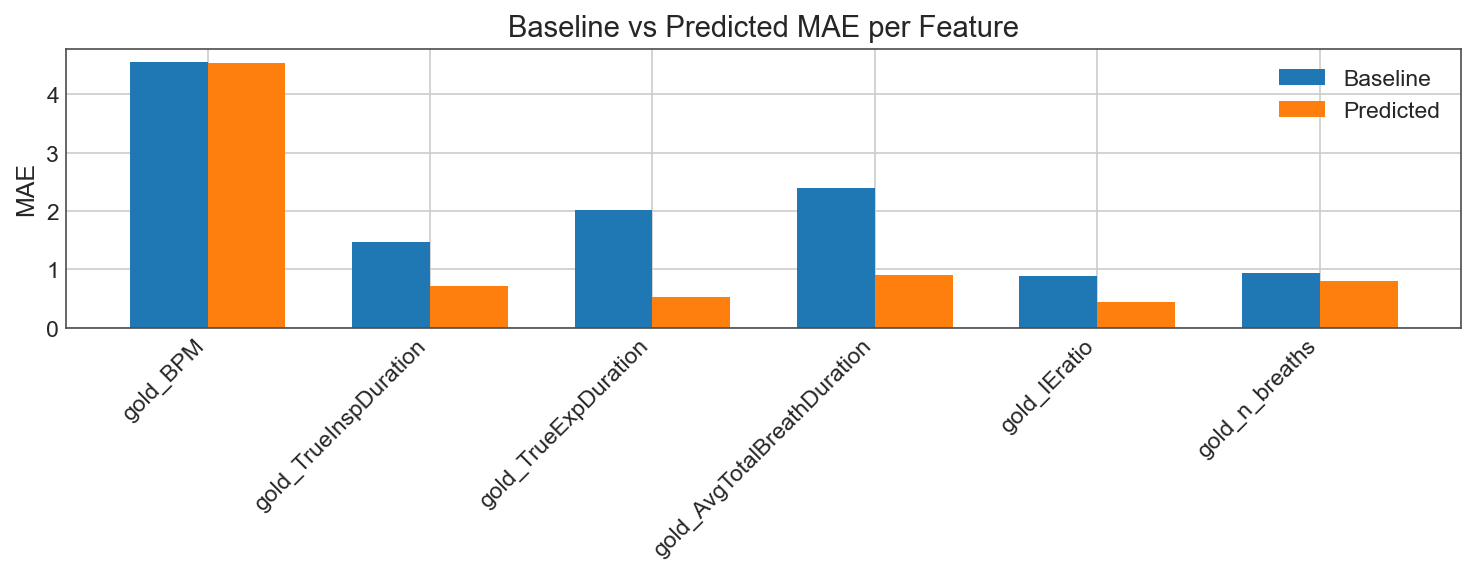


📈 Paired t-test (Baseline MAE vs Predicted MAE):
    t-statistic: 2.753
    p-value:     0.0402
Statistically significant improvement (p < 0.05)


In [11]:
import os
import joblib
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, r2_score
from scipy.stats import ttest_rel


plt.style.use('seaborn-v0_8-whitegrid')
plt.rcParams.update({
    "font.size": 12,
    "axes.titlesize": 14,
    "axes.labelsize": 12,
    "legend.fontsize": 11,
    "xtick.labelsize": 11,
    "ytick.labelsize": 11,
    "figure.dpi": 150,
    "savefig.dpi": 300,
    "figure.figsize": (10, 4),
    "axes.edgecolor": "0.3",
    "axes.linewidth": 0.8
})


DATAFILES_FOLDER = r"C:\Users\visnu\DIAMONDS\Thesis code\Datafiles"
os.makedirs(DATAFILES_FOLDER, exist_ok=True)


model_path = os.path.join(DATAFILES_FOLDER, "breath_ml_model_10.joblib")
test_path  = os.path.join(DATAFILES_FOLDER, "test_split_10.xlsx")
model = joblib.load(model_path)
df_test = pd.read_excel(test_path)


NUMERIC_COLS = [
    "EDR_BPM", "n_breaths", "AvgTotalBreathDuration",
    "TrueInspDuration", "TrueExpDuration", "IEratio"
]
CATEGORICAL_COLS = ["session_type", "exercise"]
FULL_FEATURE_COLS = NUMERIC_COLS + CATEGORICAL_COLS
TARGET_COLS = [
    "gold_BPM", "gold_TrueInspDuration", "gold_TrueExpDuration",
    "gold_AvgTotalBreathDuration", "gold_IEratio", "gold_n_breaths"
]

X_test_full = df_test[FULL_FEATURE_COLS]
X_test_num  = df_test[NUMERIC_COLS]
y_test      = df_test[TARGET_COLS]
y_test_np   = y_test.to_numpy()


preds = model.predict(X_test_full)


baseline_mae   = mean_absolute_error(y_test_np, X_test_num, multioutput='raw_values')
predicted_mae  = mean_absolute_error(y_test_np, preds, multioutput='raw_values')
baseline_r2    = r2_score(y_test_np, X_test_num, multioutput='raw_values')
predicted_r2   = r2_score(y_test_np, preds, multioutput='raw_values')


x = np.arange(len(TARGET_COLS))
bar_width = 0.35

plt.figure()
plt.bar(x - bar_width/2, baseline_mae, bar_width, label='Baseline')
plt.bar(x + bar_width/2, predicted_mae, bar_width, label='Predicted')
plt.xticks(x, TARGET_COLS, rotation=45, ha='right')
plt.ylabel('MAE')
plt.title('Baseline vs Predicted MAE per Feature')
plt.grid(True, axis='y')
plt.legend()
plt.tight_layout()
plt.savefig(os.path.join(DATAFILES_FOLDER, "mae_comparison.pdf"))
plt.show()







t_stat, p_val = ttest_rel(baseline_mae, predicted_mae)
print(f"\n📈 Paired t-test (Baseline MAE vs Predicted MAE):")
print(f"    t-statistic: {t_stat:.3f}")
print(f"    p-value:     {p_val:.4f}")

if p_val < 0.05:
    print("Statistically significant improvement (p < 0.05)")
else:
    print("❌ No significant improvement (p ≥ 0.05)")

